In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
from torchinfo import summary
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

from py.Dataset import Dataset
from py.Labels import LABELS
from py.ImageUtils import display_images
from py.FileUtils import load

DIR = '/home/kleinsteuber/vscode/ResizedSessions256_NoBackup' # dataset directory
SESSION = "beaver_01"
TRAIN_NAME = "ae2_deep_noise_sparse"

ds = Dataset(DIR)
session = ds.create_session(SESSION)

/home/kleinsteuber/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 2 sessions
Session 'Beaver_01' at folder: /home/kleinsteuber/vscode/ResizedSessions256_NoBackup/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [2]:
lapse_losses, lapse_encodings, lapse_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_lapse.pickle")
motion_losses, motion_encodings, motion_labels = load(f"./ae_train_NoBackup/{TRAIN_NAME}/eval/{session.name}_motion.pickle")

In [3]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(lapse_encodings)

In [4]:
preds = kde.score_samples(motion_encodings)
y_anom = preds[motion_labels == 1]
y_norm = preds[motion_labels == 0]

In [5]:
pd.Series(y_norm).describe()

count    7.400000e+01
mean    -2.073727e+07
std      6.007246e+07
min     -3.089760e+08
25%     -1.017565e+07
50%     -7.924425e+06
75%     -2.720522e+06
max      3.167954e+02
dtype: float64

In [6]:
pd.Series(y_anom).describe()

count    6.210000e+02
mean    -2.110057e+08
std      3.090626e+08
min     -1.801623e+09
25%     -1.874621e+08
50%     -7.601582e+07
75%     -4.367579e+07
max     -7.580517e+05
dtype: float64

In [11]:
np.array([preds[motion_labels == 1], motion_losses[motion_labels == 1]]).transpose().shape

(621, 2)

In [20]:
mode = "loss"

if mode == "kde":
    y_anom = preds[motion_labels == 1]
    y_norm = preds[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss":
    y_anom = motion_losses[motion_labels == 1]
    y_norm = motion_losses[motion_labels == 0]
    X = np.concatenate([y_norm, y_anom]).reshape((-1, 1))
    y = np.concatenate([-np.ones_like(y_norm), np.ones_like(y_anom)])
elif mode == "loss,kde" or mode == "kde,loss":
    y_anom = np.array([preds[motion_labels == 1], motion_losses[motion_labels == 1]]).transpose()
    y_norm = np.array([preds[motion_labels == 0], motion_losses[motion_labels == 0]]).transpose()
    X = np.concatenate([y_norm, y_anom])
    y = np.concatenate([-np.ones((y_norm.shape[0])), np.ones((y_anom.shape[0]))])
else:
    raise ValueError("unknown mode")

clf = LogisticRegression().fit(X, y)
clf.score(X, y)

0.8935251798561151

In [21]:
def eval_test(df_threshold = 0):
    test_results = np.where(clf.decision_function(X) >= df_threshold, np.ones(y.shape[0]), -np.ones(y.shape[0]))

    accuracy = np.mean(test_results == y)
    tar = np.sum((test_results == 1) & (y == 1)) / np.sum(y == 1)
    tnr = np.sum((test_results == -1) & (y == -1)) / np.sum(y == -1)
    far = np.sum((test_results == 1) & (y == -1)) / np.sum(y == -1)
    fnr = np.sum((test_results == -1) & (y == 1)) / np.sum(y == 1)
    precision = (np.sum((test_results == 1) & (y == 1)) / np.sum(test_results == 1)) if np.any(test_results == 1) else 0

    return accuracy, tar, tnr, far, fnr, precision

accuracy, tar, tnr, far, fnr, precision = eval_test()

print(f"Accuracy:                               {accuracy:.3f}")
print(f"True anomalous rate (must be high!):    {tar:.3f} \t - How many animals are detected as animals? (recall)")
print(f"True normal rate (higher is better):    {tnr:.3f} \t - How many empties are detected as empties?")
print(f"False anomalous rate (lower is better): {far:.3f} \t - How many empties are detected as animals?")
print(f"False normal rate (must be low!):       {fnr:.3f} \t - How many animals are detected as empties?")
print(f"Precision (higher is better):           {precision:.3f} \t - How many detected animals are actually animals?")

Accuracy:                               0.894
True anomalous rate (must be high!):    1.000 	 - How many animals are detected as animals? (recall)
True normal rate (higher is better):    0.000 	 - How many empties are detected as empties?
False anomalous rate (lower is better): 1.000 	 - How many empties are detected as animals?
False normal rate (must be low!):       0.000 	 - How many animals are detected as empties?
Precision (higher is better):           0.894 	 - How many detected animals are actually animals?


In [32]:
df_threshold_range = (2.12, 2.135, 0.0001)
num_points = len(np.arange(*df_threshold_range))
print(f"{num_points} points")
eval_results = np.empty((num_points, 7))

for i, df_threshold in tqdm(enumerate(np.arange(*df_threshold_range))):
    metrics = eval_test(df_threshold)
    eval_results[i] = [df_threshold, *metrics]

150 points


150it [00:00, 2539.24it/s]


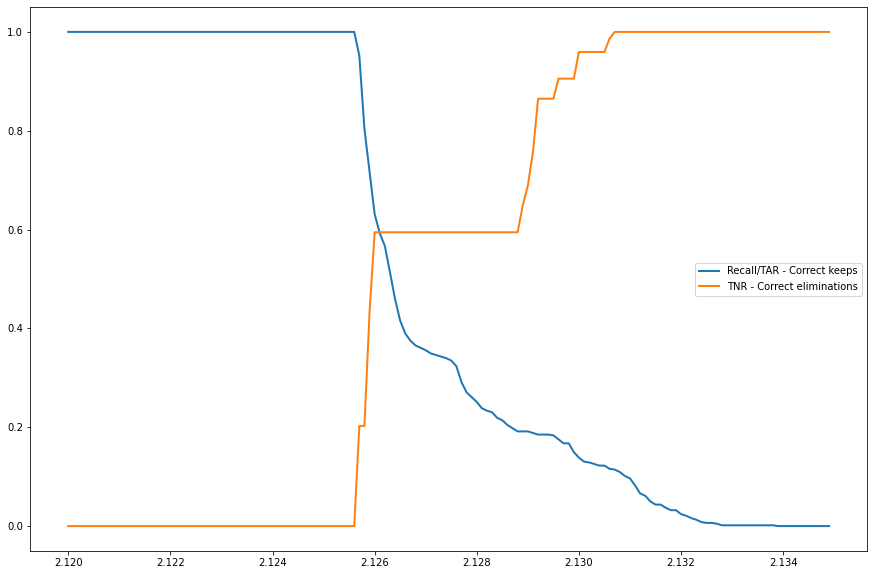

In [33]:
metrics_names = ["Accuracy", "Recall/TAR - Correct keeps", "TNR - Correct eliminations", "FAR", "FNR", "Precision"]
enable_metrics = [1, 2]
plt.figure(figsize=(15, 10))
for i, metrics_name in enumerate(metrics_names):
    if i in enable_metrics:
        plt.plot(eval_results[:,0], eval_results[:,(i+1)], label=metrics_name, linewidth=2)
plt.legend()
plt.show()

In [43]:
i = 0
while eval_results[i+1,2] >= 0.99:
    i += 1
print(f"threshold = {eval_results[i,0]}, recall = {eval_results[i,2]}, tnr = {eval_results[i,3]}")

threshold = 0.599999999999774, recall = 1.0, tnr = 1.0
